Step 1: Preprocessing

In [1]:
import pandas as pd


# preprocessing was done in the "data/processed" folder of this repo
df = pd.read_csv('../data/processed/stroke_processed.csv')

# List of categorical columns to one-hot encode
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# One-hot encode the categorical columns and drop the original columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

print(df.dtypes)

age                               float64
hypertension                        int64
heart_disease                       int64
avg_glucose_level                 float64
bmi                               float64
stroke                              int64
gender_Female                        bool
gender_Male                          bool
ever_married_No                      bool
ever_married_Yes                     bool
work_type_Govt_job                   bool
work_type_Never_worked               bool
work_type_Private                    bool
work_type_Self-employed              bool
Residence_type_Rural                 bool
Residence_type_Urban                 bool
smoking_status_Unknown               bool
smoking_status_formerly smoked       bool
smoking_status_never smoked          bool
smoking_status_smokes                bool
dtype: object


In [2]:
from sklearn.model_selection import train_test_split


# split the data into training and testing
X = df.drop(columns=['stroke'])
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(4088, 19)
(4088,)
(1022, 19)
(1022,)


In [3]:
# Check the stroke distribution in the train and test sets, they should be the same
print(f"Training set class distribution: \n{y_train.value_counts(normalize=True)}")
print(f"\nTest set class distribution: \n{y_test.value_counts(normalize=True)}")

Training set class distribution: 
stroke
0    0.951321
1    0.048679
Name: proportion, dtype: float64

Test set class distribution: 
stroke
0    0.951076
1    0.048924
Name: proportion, dtype: float64


Step 2: Tuning Hyperparameters (optimizing for F1 score)

In [4]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


# set grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'scale_pos_weight': [1, 10, 20, 50],
}
# optimize for f1
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters for F1 Score: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_}")

Best parameters for F1 Score: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 10}
Best F1 Score: 0.2722777526550672


Step 3: Evaluating Model (optimizing for F1 score)

In [5]:
from xgboost import XGBClassifier


# best parameters for optimizing F1 score according to grid seach
model = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=50, scale_pos_weight=10)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# making predictions
y_pred = model.predict(X_test)

# accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# precision, recall, and F1 scores for stroke = 0
precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

# precision, recall, and F1 scores for stroke = 1
precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

print(f"Precision for class 0: {precision_0 * 100:.2f}%")
print(f"Recall for class 0: {recall_0 * 100:.2f}%")
print(f"F1 Score for class 0: {f1_0 * 100:.2f}%")

print(f"Precision for class 1: {precision_1 * 100:.2f}%")
print(f"Recall for class 1: {recall_1 * 100:.2f}%")
print(f"F1 Score for class 1: {f1_1 * 100:.2f}%")

Accuracy: 0.8385518590998043
Precision for class 0: 97.98%
Recall for class 0: 84.77%
F1 Score for class 0: 90.90%
Precision for class 1: 18.23%
Recall for class 1: 66.00%
F1 Score for class 1: 28.57%


ROC AUC Score: 0.8438


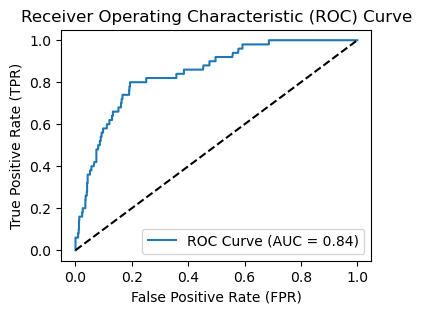

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve


# Get probabilities for class 1 (stroke patients)
y_prob = model.predict_proba(X_test)[:, 1]  

#Calculate AUC and plot the ROC curve
auc_score = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [8]:
# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Provide real world context
print(f"\nFor our {len(y_pred)} observations:\n")
print(f"{tn + fp} patients did not have a stroke")
print(f"  - {tn} patients who did not have a stroke were correctly classified as NOT having a stroke")
print(f"  - {fp} patients who did not have a stroke were INCORRECTLY classified as having a stroke\n")

print(f"{fn + tp} patients did have a stroke")
print(f"  - {tp} patients who had a stroke were correctly classified as having a stroke")
print(f"  - {fn} patients who had a stroke were INCORRECTLY classified as NOT having a stroke")



For our 1022 observations:

972 patients did not have a stroke
  - 824 patients who did not have a stroke were correctly classified as NOT having a stroke
  - 148 patients who did not have a stroke were INCORRECTLY classified as having a stroke

50 patients did have a stroke
  - 33 patients who had a stroke were correctly classified as having a stroke
  - 17 patients who had a stroke were INCORRECTLY classified as NOT having a stroke


# Project Change

Our model is suffering from class imbalance since there are significantly more non-stroke observations than stroke observations. We were not able to resolve the class imbalance issues to achieve a higher F1 score (see experiments).

We then decided to pivot to a high recall model to support our business case. A high recall model can be valuable if we assume that we can tolerate more false positives (predicting a stroke for a non-stroke patient) if we can minimize false negatives in return (predicting no stroke for a patient that suffers a stroke).

Step 4: Evaluating Model (optimizing for Recall)

In [9]:
# setup grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'scale_pos_weight': [1, 10, 20, 50],
}

# optimize for recall
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='recall', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters for recall: {grid_search.best_params_}")
print(f"Best Recall Score: {grid_search.best_score_}")

Best parameters for recall: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 50}
Best Recall Score: 0.9549223579074325


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [10]:
from xgboost import XGBClassifier


# optimized for recall
model = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, scale_pos_weight=50)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
# predict results
y_pred = model.predict(X_test)

# accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# precision, recall, and F1 scores for stroke = 0
precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

# precision, recall, and F1 scores for stroke = 1
precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

print(f"Precision for class 0: {precision_0 * 100:.2f}%")
print(f"Recall for class 0: {recall_0 * 100:.2f}%")
print(f"F1 Score for class 0: {f1_0 * 100:.2f}%")

print(f"Precision for class 1: {precision_1 * 100:.2f}%")
print(f"Recall for class 1: {recall_1 * 100:.2f}%")
print(f"F1 Score for class 1: {f1_1 * 100:.2f}%")

Accuracy: 0.4452054794520548
Precision for class 0: 99.51%
Recall for class 0: 41.87%
F1 Score for class 0: 58.94%
Precision for class 1: 7.83%
Recall for class 1: 96.00%
F1 Score for class 1: 14.48%


ROC AUC Score: 0.8389


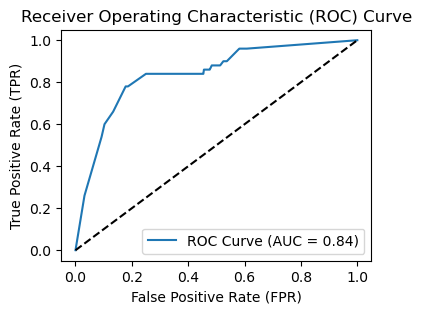

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve


# Get probabilities for class 1 (stroke patients)
y_prob = model.predict_proba(X_test)[:, 1]  

#Calculate AUC and plot the ROC curve
auc_score = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [13]:
# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Real world context
print(f"\nFor our {len(y_pred)} observations:\n")
print(f"{tn + fp} patients did not have a stroke")
print(f"  - {tn} patients who did not have a stroke were correctly classified as NOT having a stroke")
print(f"  - {fp} patients who did not have a stroke were INCORRECTLY classified as having a stroke\n")

print(f"{fn + tp} patients did have a stroke")
print(f"  - {tp} patients who had a stroke were correctly classified as having a stroke")
print(f"  - {fn} patients who had a stroke were INCORRECTLY classified as NOT having a stroke")



For our 1022 observations:

972 patients did not have a stroke
  - 407 patients who did not have a stroke were correctly classified as NOT having a stroke
  - 565 patients who did not have a stroke were INCORRECTLY classified as having a stroke

50 patients did have a stroke
  - 48 patients who had a stroke were correctly classified as having a stroke
  - 2 patients who had a stroke were INCORRECTLY classified as NOT having a stroke


# Conclusion (Part 1)

Assuming that our model was used for determining which patients should recieve stroke prevention treatment, a high recall model may lead to better public health outcomes as long as the stroke prevention treatments are not too expensive, too invasive, or too determintial in one way or another.

Step 5: Which variables significantly predict the occurence of stroke?

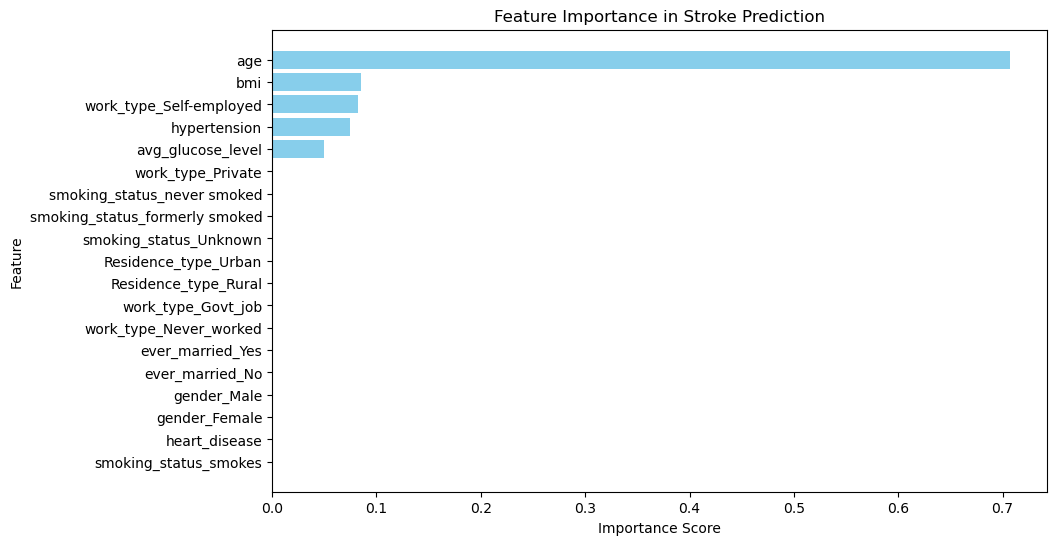

,Feature,Importance
0,age,0.707165
4,bmi,0.085441
12,work_type_Self-employed,0.082660
1,hypertension,0.074782
3,avg_glucose_level,0.049953
11,work_type_Private,0.000000
17,smoking_status_never smoked,0.000000
16,smoking_status_formerly smoked,0.000000
15,smoking_status_Unknown,0.000000
14,Residence_type_Urban,0.000000


In [14]:
# plot feature importance
feature_importances = model.feature_importances_

feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance in Stroke Prediction')
plt.gca().invert_yaxis()
plt.show()

importance_df

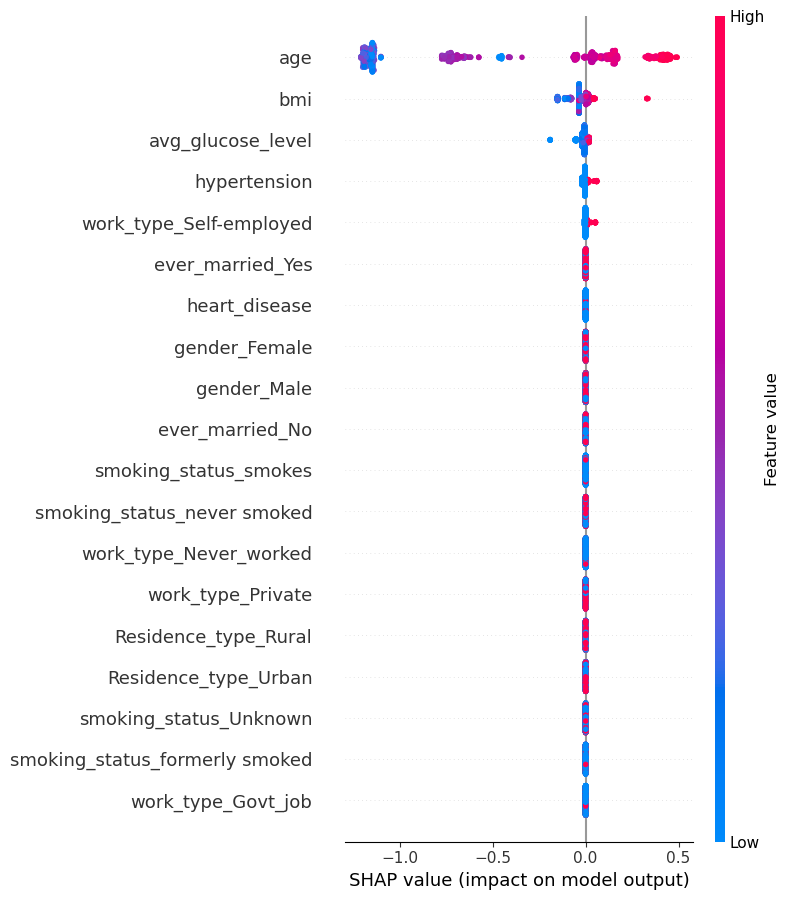

In [15]:
import shap

# SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# Conclusion (Part 2)

From feature importance and SHAP, the variables which significantly predict the occurence of stroke are Age, BMI, Work Type (Self-employed), Hypertension, and Average Glucose Level.

Age: The most significant predictor of stroke in our model, the higher the age the greater occurence of stroke

BMI: The higher the BMI the greater occurence of stroke

Work Type (Self-employed): Being self-employed has a greater occurence of stroke

Hypertension: Having hypertension has a greater occurence of stroke

Average Glucose Level: The higher the average glucose level, the greater occurence of stroke